In [104]:
from IPython.display import Image
from IPython.core.display import HTML 

For my project I chose to use a dataset that I used for work. I work at the Broad Institute of MIT and Harvard, a nonprofit genetic research center in Cambridge, MA. I work in the field of DNA sequencing - specifically, in single-cell RNA sequencing.

Quick refresher on gene expression:
Within every cell, every gene within our DNA gets transcribed (in other words, copied and "translated") into an RNA molecule, which then gets translated into protein that serves a specific function within the cell. This fundamental process behind gene expression. 

In [105]:
Image(url='https://cdn.technologynetworks.com/tn/images/thumbs/jpeg/640_360/transcription-vs-translation-worksheet-323080.jpg?v=10331049', width=500)

Every tissue - and every cell within those tissues - have different genes (proteins) expressed at different levels.  Gene expression changes in diseased tissues as well, including cancer.  There are a lot of segments in our genomic DNA that do not actually code for functioning genes; some segments simply regulate  other genes, some segments are completely dormant, and some segments are still not yet understood. This is why it is important to study the RNA levels in cells: so we can understand how varying gene expression affects cellular functionality.

In the past we had only been able to perform "bulk" RNA sequencing - due to technology limitations we could only extract RNA from a bulk population of cells taken from a tissue sample. This is useful when trying to understand varying gene expression across different tissues, but it is important to understand that within every tissue (and every tumor) there are smaller groups of cell types that serve different purposes within the tissue. 

It was only in the past few years that we have been able to isolate single cells from a tissue sample and extract high-quality DNA libraries to be sequenced.  This new technology, elected in 2018 as Science's Scientific Breakthrough of the Year, enables us to see exactly what genes are expressed in a cell, and at what levels.  

This technology uses microscopic oil-emulsion droplets to separate each cell from a live tissue sample. Within droplet is a single cell and a functionalized magnetic bead, called a a "GEM" bead, with unique molecular "barcodes" (unique DNA sequences) attached to its surface.  

On each GEM bead there are DNA molecules containing specific sequences that 1) bind to the RNA so we can purify it, and 2) tags the RNA molecules from each cell with a unique "barcode" so we can identify it later on.

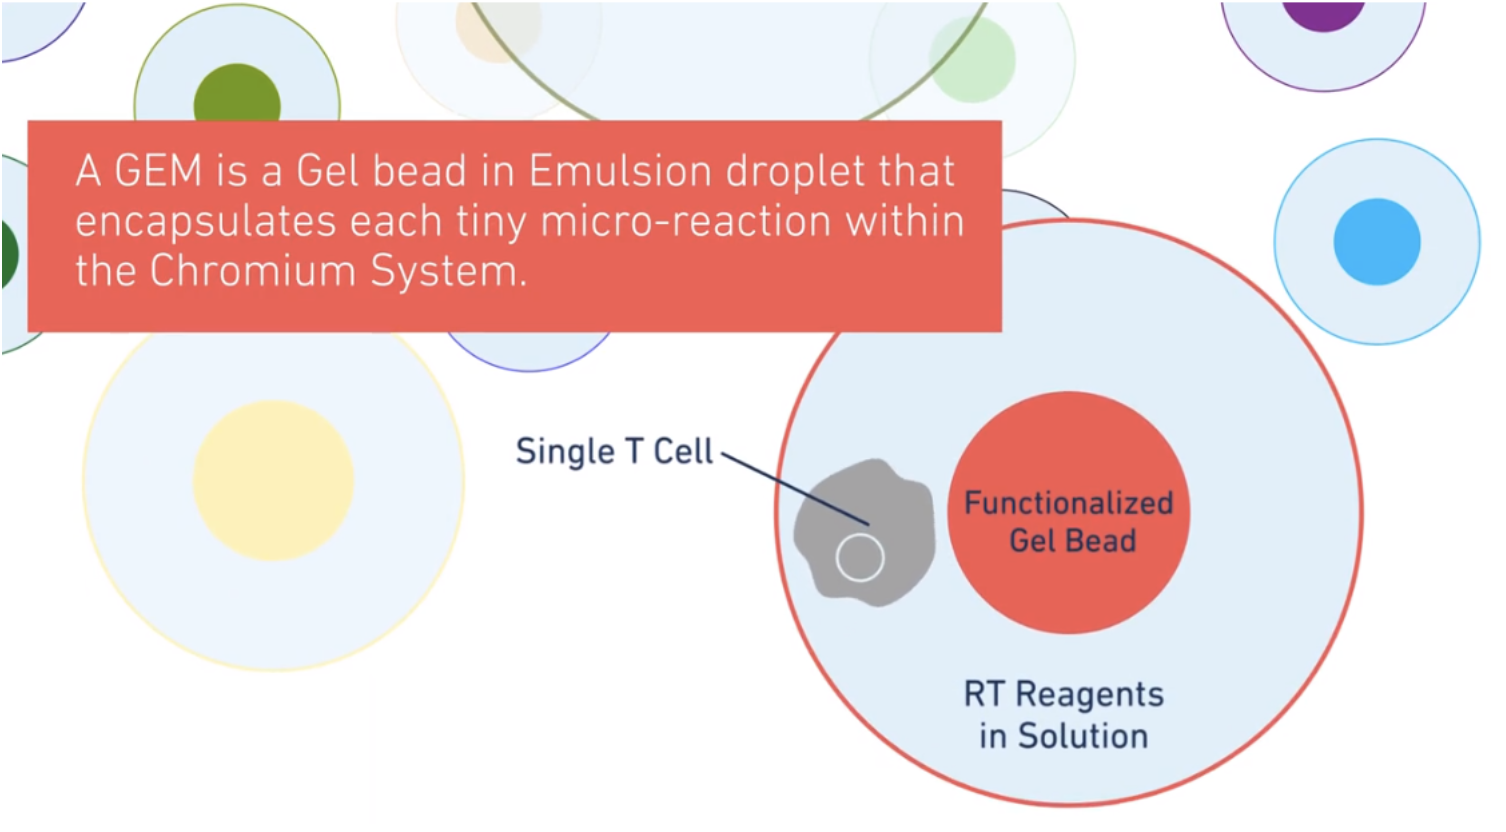

In [106]:
Image(filename='Pictures/Screen Shot 2019-12-13 at 10.32.16 AM.png', width=500)

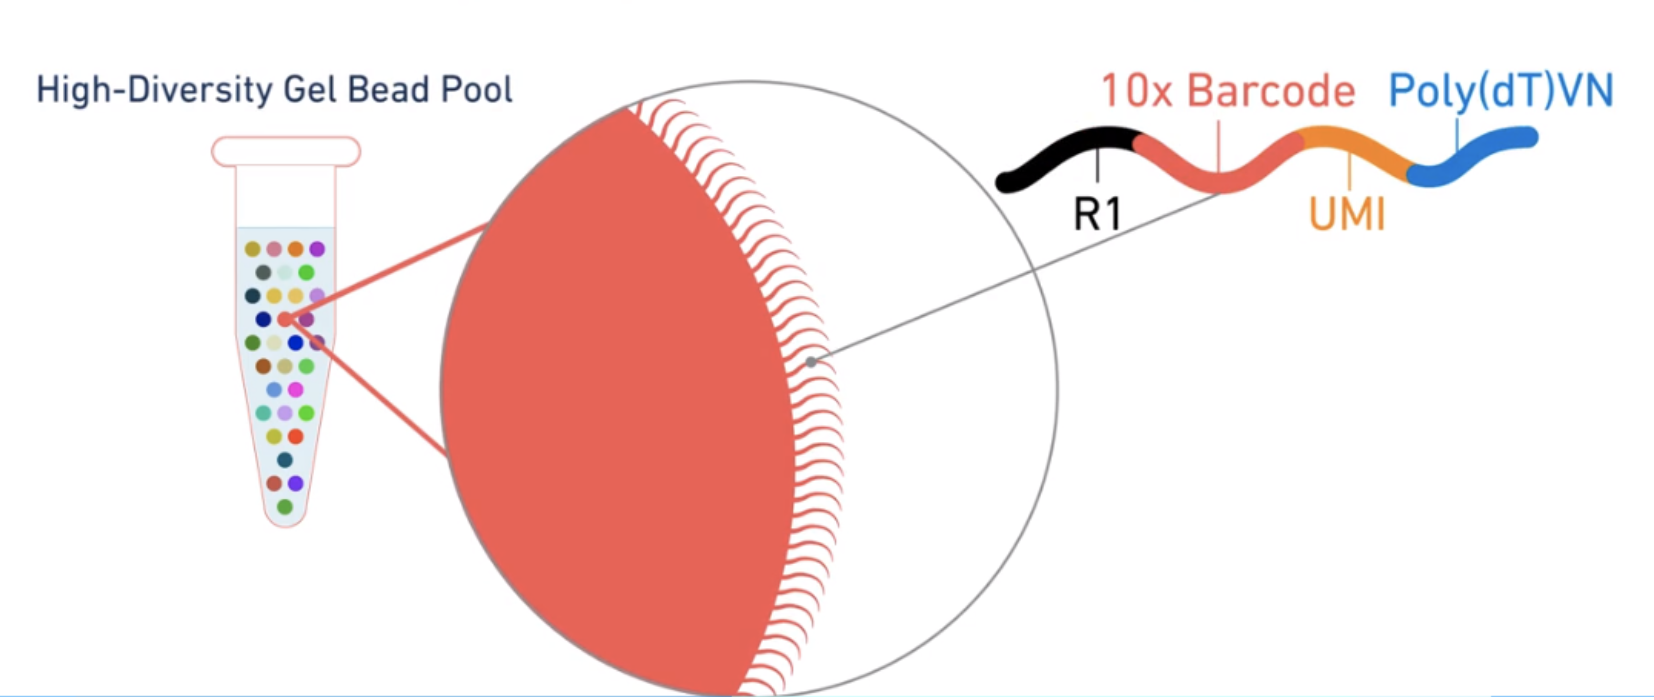

In [107]:
Image(filename='Pictures/Screen Shot 2019-12-13 at 10.32.29 AM.png', width=500)

If you want to understand more on the molecular-level:

As seen in the photo above, each bead barcode contains:
- Read 1 Primer (R1): This DNA primer sequence binds our DNA libraries to the actual sequencer machine, "tethering" it in place so we can read our DNA sequence base-by-base
- the 10X barcode: this uniquely "tags" the RNA molecules from each cell. It acts as an ID tag and allows us to de-multiplex our raw data back down to the individual cell
- the Unique Molecular Index: this uniquely tags each RNA molecule. It is mostly used to detect duplicate RNA reads so we can filter them out 
- the poly(dT) tail: This is simply a consecutive sequence of only T bases. (Remember DNA base pairing: A binds to T, C binds to G.) Our RNA molecules of interest have a sequence of only A bases, called the poly-A tail.  The bead's poly-T sequence binds to the RNA's poly-A sequence, thereby capturitng the RNA so we can later purify it.

Next we add reagents to lyse (break open) the cells - this releases the RNA from inside and exposes them to the bead's surface molecules, to which they bind. The beads are magnetic, so we actually use magnets to purify the bead-bound RNA from the rest of the "junk" molecules in our sample. 

In [108]:
Image(url="https://ars.els-cdn.com/content/image/1-s2.0-S0960894X14011251-fx1.jpg")

(If you are interested in learning more about DNA sample prep & sequencing technology, here is a quick 5-minute video that breaks it down nicely: https://www.youtube.com/watch?v=fCd6B5HRaZ8)

After we get our raw DNA reads from the sequencer, we run it through computationally-intensive pipelines that piece together all of our RNA reads back together and align them to a human reference genome. Using this reference, the pipeline detects which genes are present in our sample. The output of the pipeline is a "count matrix".

In [109]:
Image(url='https://support.10xgenomics.com/img/cellranger-atac-workflows/Agora_MultiSamples_MultiGEMwells_1Flowcell.png')

In the count matrix, rows represent genes & columns represent individual cells, and each element contains the number of times a gene was detected (the gene count) in a single cell. In other words this count matrix represents the expression level of every gene, one cell at a time. 
(It also contains additional annotations to identify each cell back to its original sample.)

Once we get the count matrix we can load into Python to perform additional manual analysis. (We will go more into this data object later.)

As you can imagine, the cost of this process is quite expensive - about $2,000 per sample. In order to perform meaningful scientific studies, you typically need at least a few hundred - sometimes up to thousands - of samples from different patients. 

To "cheat" the system and save on costs, scientists developed a way to combine multiple samples into one 10X run. This process is called "Cell Hashing".  Basically, they use antibodies (with a known sequence) to tag each sample before combining them into a single tube. After our DNA is sequenced, we use the antibody sequences to tell each sample apart. 

The main benefits to this process is a drastic cost reduction (up to 8-fold) as well as mitigating batch effects. 

In [110]:
Image(url= "https://citeseq.files.wordpress.com/2018/02/cell_hashing.png?w=1400")

For Part I of my project I will be using data from our validation experiment of the Cell Hashing process.  

In our validation experiment, we tagged 8 different samples and combined them into one run. Four of the samples were HEK (liver) cells, and the other four samples were A375 (melanoma).  

I used the following tutorial to guide my analysis:
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

The goal of this analysis is to 1) identify all 8 of our original samples within the data, and 2) cluster the cells and ensure that there are only two clusters, one for A375 cells and another for HEK cells.

For Part II of my project, I will take data from a different experiment and run it through Part I's clustering methods to compare and classify different cell types. 

__Part I__

The gene-count matrix is a multi-dimensional annotated matrix. The Python object is called an AnnData matrix. It is part of the scanpy package (Single Cell Analysis for Python) that was built specifically for single cell sequencing analysis. Conveniently this AnnData objects were designed to be handled and spliced similar to pandas DataFrames. 

AnnData documentation:
https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html

Scanpy documentation:
https://scanpy.readthedocs.io/en/stable/

At its core, an AnnData object stores a data matrix "X", which is our count matrix as described above. The columns are paired with a variables matrix ("var") where each variable/column represents a unique gene, and the rows are paired with an observations matrix ("obs") where each observation/row represents an individual cell. 

There is a fourth (and less important) matrix for unstructured annotations ("uns"), which contains reads that did not align to any genes (these are called orphaned reads).

In [111]:
Image(url= "https://falexwolf.de/img/scanpy/anndata.svg")

So...let's start digging into it!

__Loading in the Data__

Let's import some packages we're going to need:

In [112]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata

And some recommended settings:

In [113]:
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity=3
#verbosity: errors (0), warnings(1), info(2), hints(3)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


After doing some pre-processing, we're going to want to save our processed matrix. Let's create a file now that we can save to later:

In [114]:
#the file that will store our processing results
results_file='./PartI_filtered.h5ad' 

I have previously run through the data through our pipelines to get the output that we can actually work with. Let's load that in:

In [115]:
#read in our data
adata=anndata.read_h5ad('/Users/caroline/Desktop/Hashed_analysis/Hashed_secondary_output_Hashed_Hashed_demux.h5ad')
adata

AnnData object with n_obs × n_vars = 70351 × 33538 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment'
    var: 'gene_ids', 'robust'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

We see that our AnnData object, adata, contains 70,351 "observations" (cells) and 33,538 "variables" (genes).

We see that our observations matrix __.obs__ contains the following attributes:

- __Channel:__ A channel = a 10x run. In this case, all of our samples were run in a single channel (that's the point of Cell Hashing).

- __n_genes:__ total genes detected within one cell

- __n_counts:__ the number of times each read occured (remember, we amplified our DNA, so there are multiple copies of the same read)

- __demux_type:__ If you recall from the introduction, the technology isolates single cells using oil droplets - sometimes, however, two or more cells end up in a single droplet, which we will need to filter out from out dataset. Demux_type tells us whether a droplet was a "singlet", "doublet" (containing 2 or more cells), or "unknown"
- __assignment:__ This tells us our sample name.  In this experiment, we have 8: 4 are HEK cells, and 4 are A375 cells.

The variables matrix __.vars__ contains:

- __gene_ids:__ The abbreviated name for each gene

- __robust:__ a measure of how well the read sequence aligns to the reference gene

__Validate__

Let's take a look at our observations matrix to see how the demultiplexing worked.

In [116]:
samp=adata.obs
samp

Channel  n_genes  n_counts demux_type              assignment
index                                                                         
AAACCCAAGACAACTA              368     536.0    doublet  A375_15,A375_13,HEK_10
AAACCCAAGACGGTTG              347     491.0    doublet           HEK_8,A375_15
AAACCCAAGAGAATCT              317     472.0    unknown                        
AAACCCAAGAGCTTTC              352     509.0    unknown                        
AAACCCAAGATACAGT              369     534.0    unknown                        
...                  ...      ...       ...        ...                     ...
TTTGTTGTCGTCGACG              257     325.0    unknown                        
TTTGTTGTCTCCAATT              285     367.0    unknown                        
TTTGTTGTCTCGAGTA              260     330.0    singlet                  HEK_10
TTTGTTGTCTTAATCC              276     351.0    unknown                        
TTTGTTGTCTTCGACC              253     321.0    doublet           HEK_8,A375_15

[70351 rows x 5 columns]

On the left we see the index, which is the unique sequence (our antibody "barcode") that was used to ID each read. We cab see the number of genes detected within each read, the number of times this read appeared (the count), the demultiplex type (whether there was 1 or more cells per droplet. We can also see the "assignment", the sample from which each read originated from.

Our samples are: HEK 2, 8, 10, 12, and A375 9, 13, 14, 15.

__EDA__

Now let's sort our reads by their assignment. If our experiment worked, we will see our 8 samples listed at the top with the highest number of reads.

In [117]:
samp.assignment.value_counts().head(25)

                   31871
HEK_8               5818
HEK_2               3739
HEK_12              3639
HEK_10              3119
A375_14             2996
A375_13             2272
A375_15             1860
A375_9              1474
HEK_8,A375_13        719
HEK_8,HEK_10         607
HEK_8,A375_14        563
HEK_8,HEK_12         505
A375_14,HEK_8        460
HEK_8,A375_15        458
HEK_10,HEK_8         445
HEK_12,HEK_8         376
A375_13,HEK_8        301
HEK_10,A375_13       264
HEK_12,A375_13       263
HEK_2,HEK_8          236
A375_14,A375_13      230
HEK_8,A375_9         225
A375_15,HEK_8        223
HEK_10,HEK_12        220
Name: assignment, dtype: int64

As expected, we see that all 8 of our samples make up our top reads. Our experiment was a success!

However, we do see that there are a high rate of doublets. This is a sign that we loaded our instrument at too high of a concentration - by over-saturating the machine, you increase your chances that every droplet will have more than 1 cell. 

__Initial filtering:__
We will want to filter out anything that is not a singlet:

In [118]:
#filter out doublets, triplets & unknowns
adata=adata[adata.obs['demux_type']=='singlet']
adata

View of AnnData object with n_obs × n_vars = 24917 × 33538 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment'
    var: 'gene_ids', 'robust'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

We see that we actually only has 24,917 single cells detected. 

We'll still want to do a bit more filtering. First we will filter out any cells that had 200 or fewer genes (these are likely dead cells). We will also filter out any genes that are present in 3 or fewer cells (these are anomolies and should be excluded).
To do this we will use built-in functions from the scanpy package.

In [119]:
#filtering out low genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 91 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 11892 genes that are detectedin less than 3 cells


The next thing we want to do is filter out any mitochondrial reads.  Mitochondria (an organelle within a cell) actually have a different genome from the rest of the cell - therefore we want to exclude the mitochondrial reads because it will confound our other findings.  

High mitochondrial reads is actually representative of dying cells in our sample. The cells are still alive in the beginning of the process, and sometimes they get "stressed out" from being poorly handled and die, releasing the mitochondrial RNA and altering the regular gene expression. 

In [120]:
#calculate mitochondrial genes detected
mito_genes=adata.var_names.str.startswith('MT-')
#for each cell, compute fraction of counts in mito genes vs all genes
#the '.A1' is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito']=np.sum(adata[:, mito_genes].X, axis=1).A1/np.sum(adata.X, axis=1).A1
#add the total counts per cell as observations-annotation to adata
adata.obs['n_counts']=adata.X.sum(axis=1).A1
#let's take a look:
adata.obs

Channel  n_genes  n_counts demux_type assignment  \
index                                                               
AAACCCAAGATAGCAT              346     477.0    singlet      HEK_8   
AAACCCAAGCCGAATG              386     558.0    singlet      HEK_8   
AAACCCAAGCCTCAAT             4742   19631.0    singlet      HEK_2   
AAACCCAAGCCTCCAG              413     568.0    singlet    A375_14   
AAACCCAAGCTGCGAA              400     592.0    singlet     HEK_10   
...                  ...      ...       ...        ...        ...   
TTTGTTGGTTTAGTCG             2797    8334.0    singlet     HEK_12   
TTTGTTGTCAGAGCGA             1487    3252.0    singlet      HEK_8   
TTTGTTGTCCACTGAA             3076    9934.0    singlet     HEK_12   
TTTGTTGTCCTTATGT             3503   11319.0    singlet      HEK_2   
TTTGTTGTCTCGAGTA              260     330.0    singlet     HEK_10   

                  percent_mito  
index                           
AAACCCAAGATAGCAT      0.008386  
AAACCCAAGCCGAATG      0.012545  
AAACCCAAGCCTCAAT      0.087107  
AAACCCAAGCCTCCAG      0.010563  
AAACCCAAGCTGCGAA      0.013514  
...                        ...  
TTTGTTGGTTTAGTCG      0.166067  
TTTGTTGTCAGAGCGA      0.305966  
TTTGTTGTCCACTGAA      0.385545  
TTTGTTGTCCTTATGT      0.095857  
TTTGTTGTCTCGAGTA      0.006061  

[24826 rows x 6 columns]

__Visualize:__
Let's make some graphs:

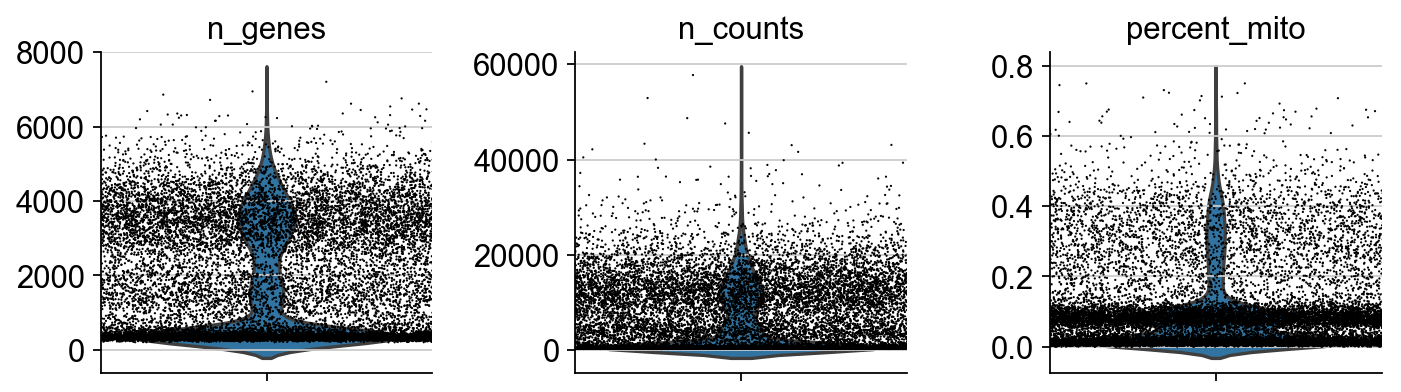

In [121]:
#a violin plot of the computed quality measures
sc.pl.violin(adata, ['n_genes','n_counts','percent_mito'], jitter=0.7, multi_panel=True)

On the left plot we see that we have a decent number of cells with ~4000 genes (which is expected for a single cell), but also a lot with almost 0 genes. We see a similar divide in the read counts: a decent amount hovers around ~18000 reads or so, but we also have a good number close to 0.  We see the same thing with % mito, as well as a lot of scattered points above 15%. Typically we want to see less than 10%) for % mito, so this is indicative that some of our cells were very stressed out & dying.

Let's plot n_genes and percent_mito against n_counts: 

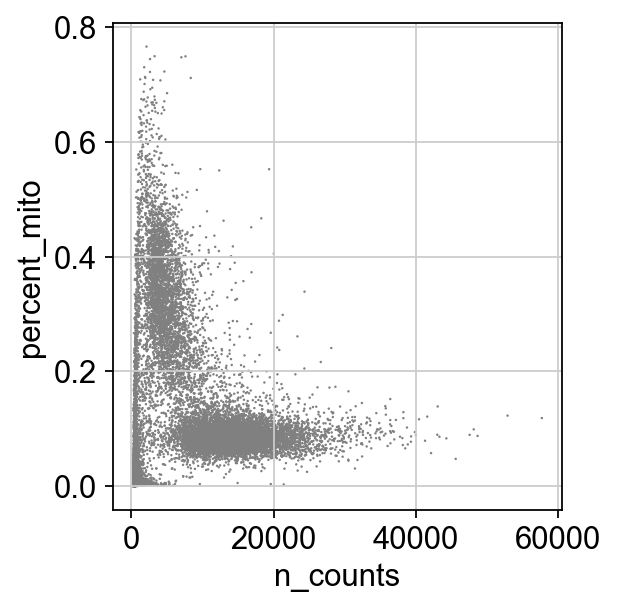

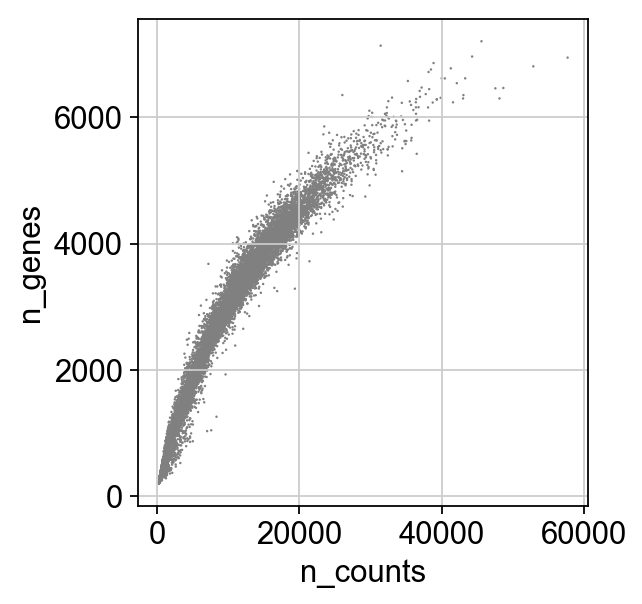

In [122]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts',y='n_genes')

In the top graph we can clearly see that there are 3 different groups: the bottom right group represents our "desired" data, where we have tens of thousands of reads per cell and a % mito of ~15%. The cluster right above that, in the middle, are our stressed out genes - not a lot of reads, and most of them were from mitochondria (because cells were stressed & dying). On the very left we see a straight-ish line with very few reads and very high % mitochondrial - these are cells that were already dead. We want to filter these last two groups out.

In the bottom graph we see that the number of genes detected is positively correlated with the number of reads detected.

__Filter some more:__

In [123]:
#filter out any cells that have less than 6000 genes (this is based off of our first graph - anything higher than this looks like an outlier)
adata=adata[adata.obs['n_genes']<6000, :]
#filter out any cells with over 5% mito (this filters out the very bottom left of the graph, where there are very few reads),and under 20% mito (to filter out our very stressed cells)
adata=adata[adata.obs['percent_mito']<0.15, :]
adata=adata[adata.obs['percent_mito']>0.05, :]
#filter out any cells with fewer than 1500 reads per cell
adata=adata[adata.obs['n_counts']>1500, :]
adata

View of AnnData object with n_obs × n_vars = 8115 × 21646 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

Looks like we're down to 8115 cells that we can actually use for our analysis. This goes to show how heavily sequencing data needs to be filtered and how mny sequencing reads get thrown out.

Let's take a look at those scatter plots again:

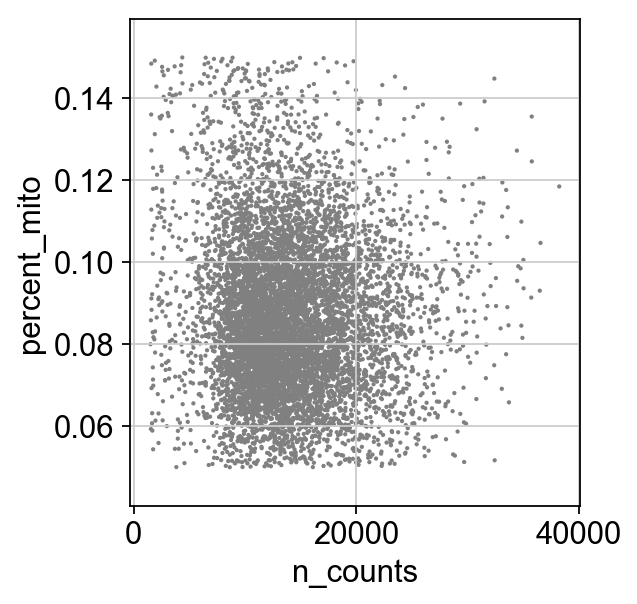

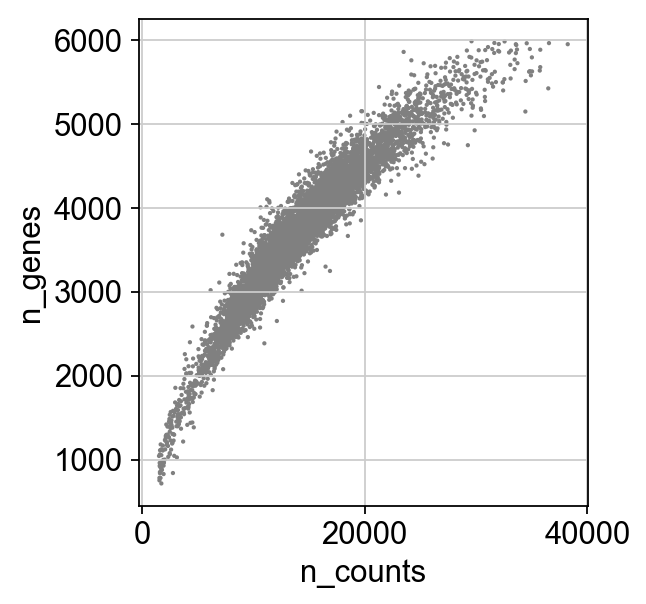

In [124]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts',y='n_genes')

Much better.

__Save our data:__

In [125]:
#save the result
adata.write(results_file)
#let's look at what adata looks like now, for reference
adata

AnnData object with n_obs × n_vars = 8115 × 21646 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

__Normalization, regression & scaling:__


Now we are going to normalize our data to 10,000 reads per cell so that the counts become comparable among cells:

In [126]:
#total count normalize (library-size correct) the data matrix 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


And then we logarithmize the data:

In [127]:
sc.pp.log1p(adata)

In [128]:
#set the .raw attribute of adata to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression.
#This simply freezes the state of the adata object
adata.raw=adata

In [129]:
#Let's also save to our results file for use later on:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 8115 × 21646 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

Now we want to identify highly variable genes. There is a function in scanpy that calculates this for us.

In [130]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Filter for highly variable genes:

In [131]:
adata=adata[:, adata.var['highly_variable']]

Now we will use a scanpy function called regress_out, which uses simple linear regression to regress out unwanted sources of variation. In our case we are regressing out the effects of total counts per cell and % mitochondrial reads. 

In [132]:
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:11)


Now we scale each gene to unit variance. 

In [133]:
# Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

__PCA__

Now we will perform PCA analysis to reduce the dimensionality of our data.

In [134]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)


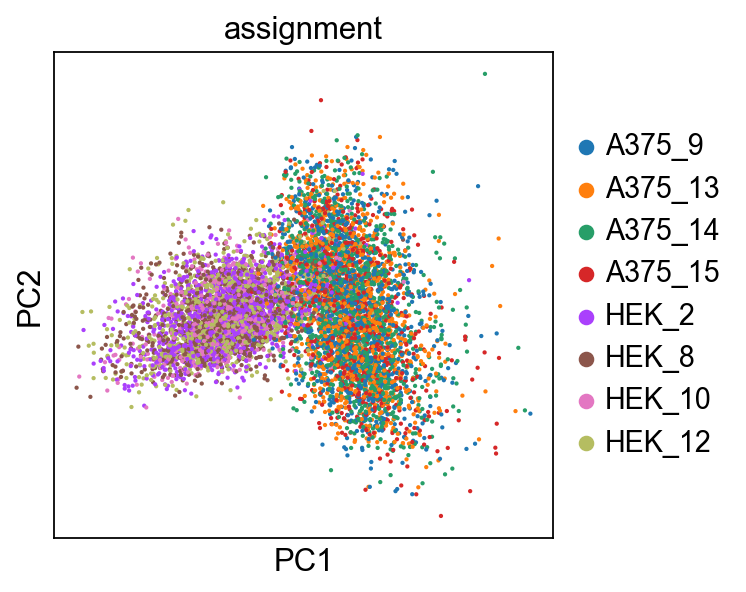

In [135]:
#scatter plot in the PCA coordinates
sc.pl.pca(adata, color='assignment')

We can see that our clusters are dependent on the cell type.

Now let's inspect the contribution of single PCs to the total variance in the data. This gives us information on how many PCs we should consider un order to compute the neighborhood relations of cells, which will be later used in our clutering function.

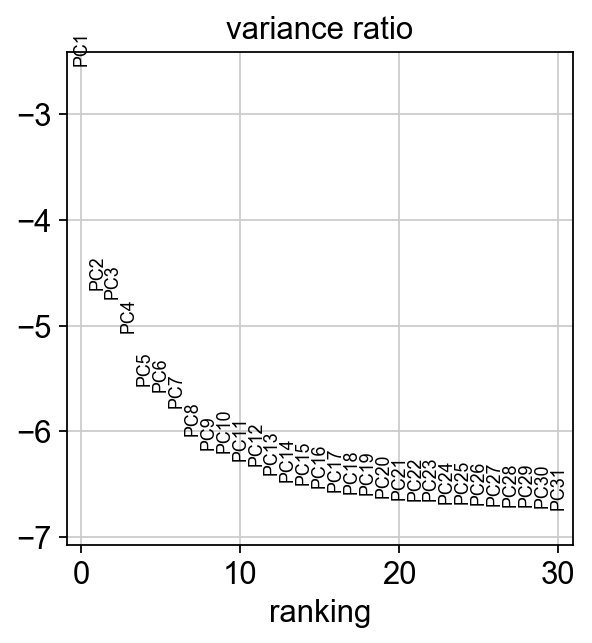

In [136]:
sc.pl.pca_variance_ratio(adata, log=True)

Looks like 15-16 PCs should be sufficient.

__Clustering__

First we will compute the neighborhood graph using the PCA representation. We call on a function called UMAP (Uniform Manifold Approximation and Projection) to further reduce the dimensionality of our data. 

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE (t-Distributed Stochastic Neighbor Embedding), but also for general non-linear dimension reduction. 

UMAP: https://umap-learn.readthedocs.io/en/latest/

t-SNE: https://lvdmaaten.github.io/tsne/

In [137]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


In [138]:
#Embedding the graph in 2 dimensions using UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


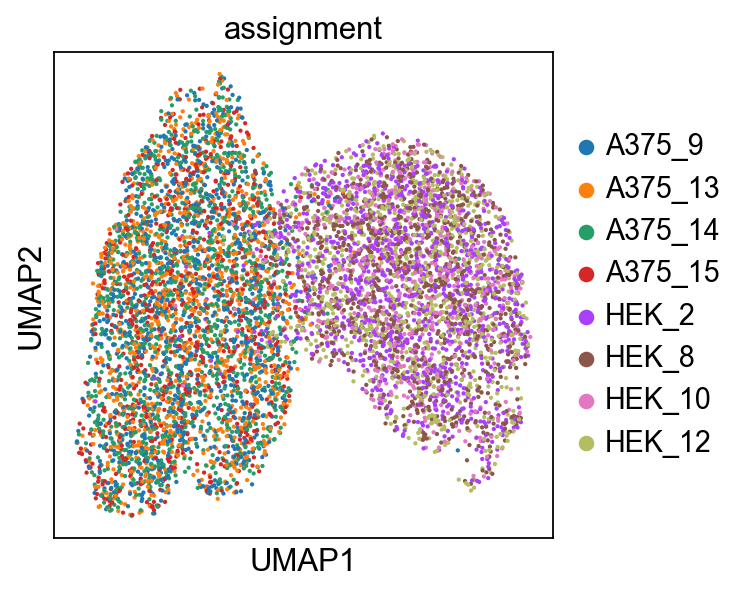

In [139]:
#visualize our clusters
sc.pl.umap(adata, color=['assignment'])

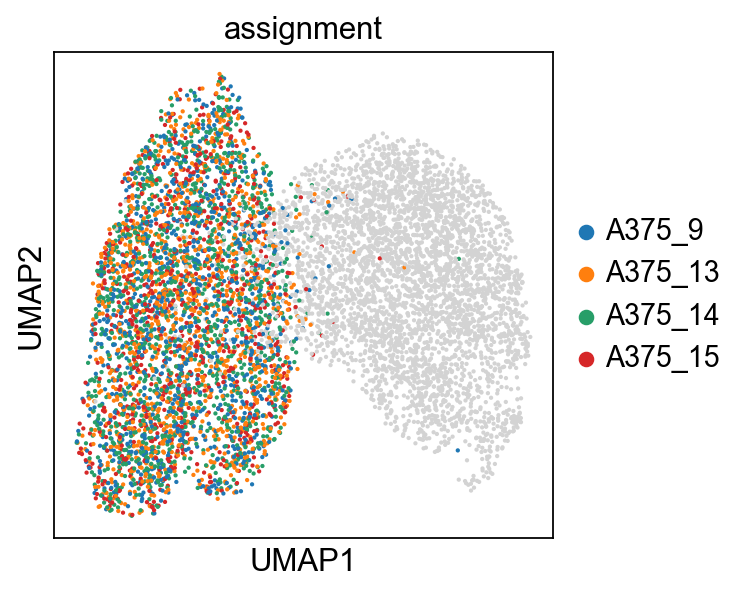

In [140]:
#visualize only A375 cells
sc.pl.umap(adata, color=['assignment'], groups=['A375_9', 'A375_13', 'A375_14', 'A375_15'])

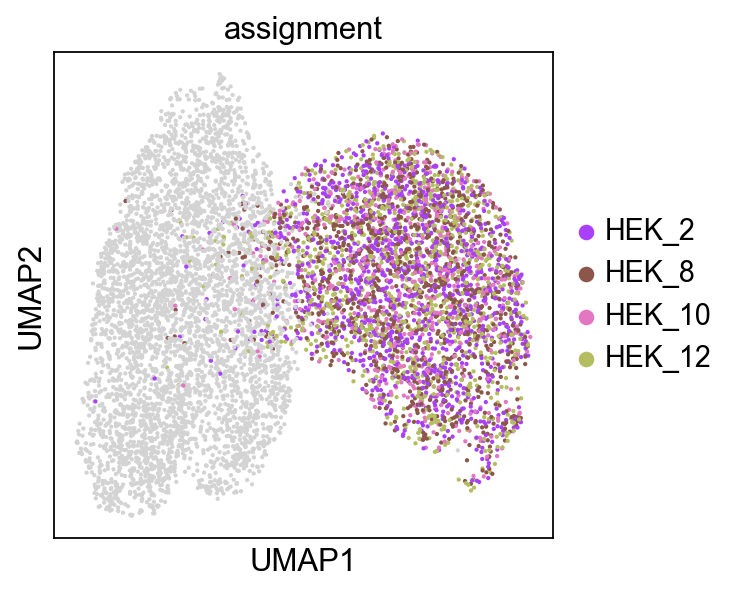

In [141]:
#visualize only HEK cells
sc.pl.umap(adata, color=['assignment'], groups=['HEK_2', 'HEK_8', 'HEK_10', 'HEK_12'])

Awesome - our clustering worked!

This wraps up the analysis for Part I.

Let's take a final peek at our processed matrix object before moving onto part II:

In [142]:
adata

AnnData object with n_obs × n_vars = 8115 × 2049 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'background_probs', 'genome', 'pca', 'assignment_colors', 'neighbors'
    obsm: 'raw_probs', 'X_pca', 'X_umap'
    varm: 'PCs'

__Part II__

Now I am going to import some data from a different experiment. This dataset contains multiple different samples but we want to extract the HEK cells from this dataset. Then, we will comncatenate the HEK data to our matrix from Part I. We will process the data as before to see how the new HEK data clusters in compartison to our Part 1 HEK cells. 

In [143]:
#new file to store analysis results
results_file2='./PartII_filtered.h5ad' 

In [144]:
#read in our new data
adataA=anndata.read_h5ad('/Users/caroline/Desktop/cumulus_output.h5ad')
adataA

AnnData object with n_obs × n_vars = 23651 × 27623 
    obs: 'Channel', 'passed_qc', 'n_genes', 'n_counts', 'percent_mito', 'louvain_labels'
    var: 'gene_ids', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'PCs', 'W_pca', 'genome', 'pca', 'pca_knn_distances', 'pca_knn_indices'
    obsm: 'X_fitsne', 'X_pca'

In [145]:
adataA.obs

Channel  passed_qc  n_genes  n_counts  \
index                                                                     
Nir_1-AAACCCAAGCAATAAC              Nir_1       True     2742    7936.0   
Nir_1-AAACCCAGTACTCGCG              Nir_1       True     1414    4776.0   
Nir_1-AAACCCAGTTGTTGAC              Nir_1       True     1568    5033.0   
Nir_1-AAACCCATCGTGGACC              Nir_1       True     1816    5090.0   
Nir_1-AAACGAAAGCAGTAAT              Nir_1       True     1367    5819.0   
...                                   ...        ...      ...       ...   
KCO_ova_TST-TTTGACTTCCTACAAG  KCO_ova_TST       True     1908    3519.0   
KCO_ova_TST-TTTGGAGAGGAGCAAA  KCO_ova_TST       True      979    1747.0   
KCO_ova_TST-TTTGGAGCATATAGCC  KCO_ova_TST       True     1445    2362.0   
KCO_ova_TST-TTTGGAGTCGAATGCT  KCO_ova_TST       True     1563    3029.0   
KCO_ova_TST-TTTGTTGCACGATAGG  KCO_ova_TST       True      800    1291.0   

                              percent_mito louvain_labels  
index                                                      
Nir_1-AAACCCAAGCAATAAC            7.497480             10  
Nir_1-AAACCCAGTACTCGCG            7.600502             13  
Nir_1-AAACCCAGTTGTTGAC            8.881383             11  
Nir_1-AAACCCATCGTGGACC            9.685658             10  
Nir_1-AAACGAAAGCAGTAAT            7.338031              9  
...                                    ...            ...  
KCO_ova_TST-TTTGACTTCCTACAAG      5.853936              5  
KCO_ova_TST-TTTGGAGAGGAGCAAA      6.639955              7  
KCO_ova_TST-TTTGGAGCATATAGCC      2.921253              1  
KCO_ova_TST-TTTGGAGTCGAATGCT      5.513371              1  
KCO_ova_TST-TTTGTTGCACGATAGG      8.210690              7  

[23651 rows x 6 columns]

In [146]:
#Let's look at the sample names in this dataset:
adataA.obs['Channel'].unique()

[Nir_1, Nir_2, Nir_3, Nir_Tissue, HEK_1, HEK_2, HEK_3, HEK_4, KCO_Ova_CST, KCO_ova_TST]
Categories (10, object): [Nir_1, Nir_2, Nir_3, Nir_Tissue, ..., HEK_3, HEK_4, KCO_Ova_CST, KCO_ova_TST]

We're only going to want the HEK samples - we'll filter out for this later.

__EDA & Filtering__

Let's take a preliminary look at the data:

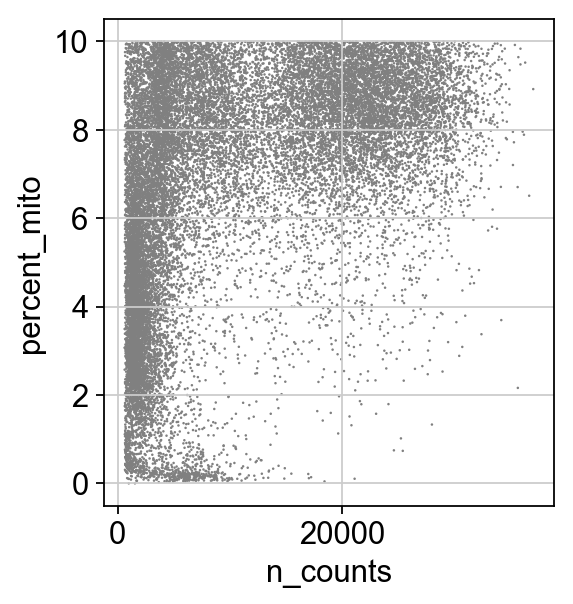

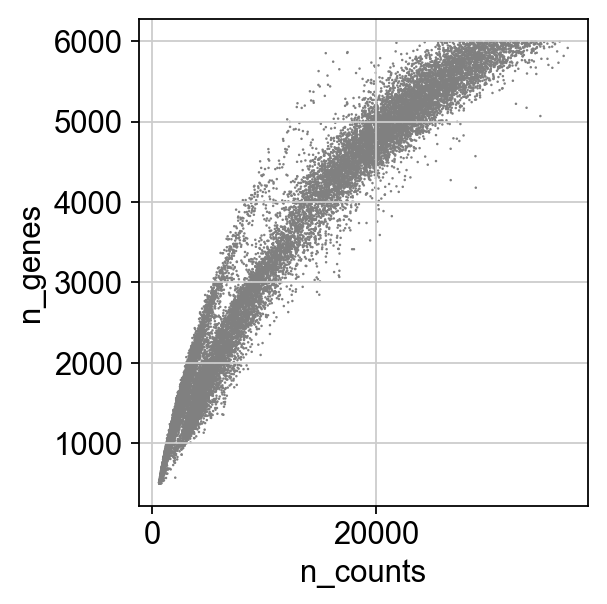

In [147]:
#plot n_genes and percent_mito against n_counts: 
sc.pl.scatter(adataA, x='n_counts', y='percent_mito')
sc.pl.scatter(adataA, x='n_counts',y='n_genes')

Looks pretty messy - hopefully filtering will clean this up.

We also see that our percent_mito is actual percentages rather than decimals. Let's change that now so it's consistent with out other dataset

In [148]:
adataA.obs.percent_mito=0.01*adataA.obs.percent_mito
adataA.obs.percent_mito

index
Nir_1-AAACCCAAGCAATAAC          0.074975
Nir_1-AAACCCAGTACTCGCG          0.076005
Nir_1-AAACCCAGTTGTTGAC          0.088814
Nir_1-AAACCCATCGTGGACC          0.096857
Nir_1-AAACGAAAGCAGTAAT          0.073380
                                  ...   
KCO_ova_TST-TTTGACTTCCTACAAG    0.058539
KCO_ova_TST-TTTGGAGAGGAGCAAA    0.066400
KCO_ova_TST-TTTGGAGCATATAGCC    0.029213
KCO_ova_TST-TTTGGAGTCGAATGCT    0.055134
KCO_ova_TST-TTTGTTGCACGATAGG    0.082107
Name: percent_mito, Length: 23651, dtype: float64

Now let's filter for the HEK samples. Let's look at our sample names again:

In [149]:
adataA.obs['Channel'].unique()

[Nir_1, Nir_2, Nir_3, Nir_Tissue, HEK_1, HEK_2, HEK_3, HEK_4, KCO_Ova_CST, KCO_ova_TST]
Categories (10, object): [Nir_1, Nir_2, Nir_3, Nir_Tissue, ..., HEK_3, HEK_4, KCO_Ova_CST, KCO_ova_TST]

Let's pick out the HEK datasets:

In [150]:
adata1=adataA[adataA.obs['Channel']=='HEK_1']
adata2=adataA[adataA.obs['Channel']=='HEK_2']
adata3=adataA[adataA.obs['Channel']=='HEK_3']
adata4=adataA[adataA.obs['Channel']=='HEK_4']

print(adata1.shape)
print(adata2.shape)
print(adata3.shape)
print(adata4.shape)

(2798, 27623)
(2488, 27623)
(2398, 27623)
(2215, 27623)


In [151]:
#concatenate
adata_HEK=adata1.concatenate(adata2, adata3, adata4)
adata_HEK

AnnData object with n_obs × n_vars = 9899 × 27623 
    obs: 'Channel', 'batch', 'louvain_labels', 'n_counts', 'n_genes', 'passed_qc', 'percent_mito'
    var: 'gene_ids', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'

In [152]:
#double check:
adata_HEK.obs.Channel.value_counts().head(5)

HEK_1    2798
HEK_2    2488
HEK_3    2398
HEK_4    2215
Name: Channel, dtype: int64

Let's see if anything did not pass qc:

In [153]:
adata_HEK.obs['passed_qc'].unique()

array([ True])

Good, we don't have to filter for that.

Let's filter out for low genes/low cells like we did in Part I:

In [154]:
#filtering out low genes
sc.pp.filter_cells(adata_HEK, min_genes=200)
sc.pp.filter_genes(adata_HEK, min_cells=3)

filtered out 6759 genes that are detectedin less than 3 cells


... storing 'Channel' as categorical


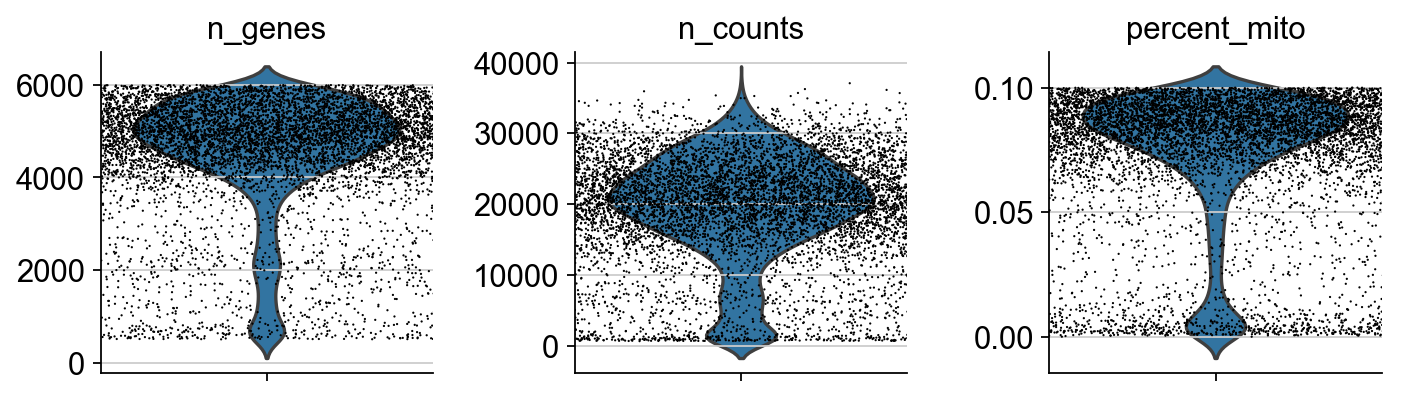

In [155]:
#Let's visualize
sc.pl.violin(adata_HEK, ['n_genes','n_counts','percent_mito'], jitter=0.7, multi_panel=True)

Note: I think the pipeline I ran before has an automatic filter for cells over 10% mito, which is why there's a sharp cut off

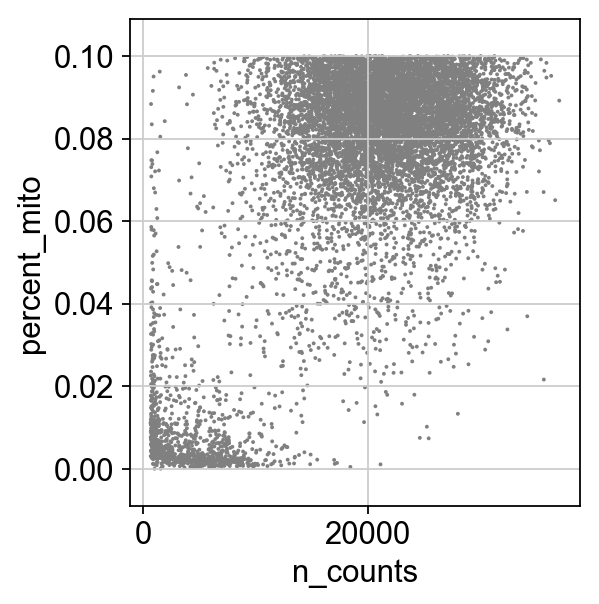

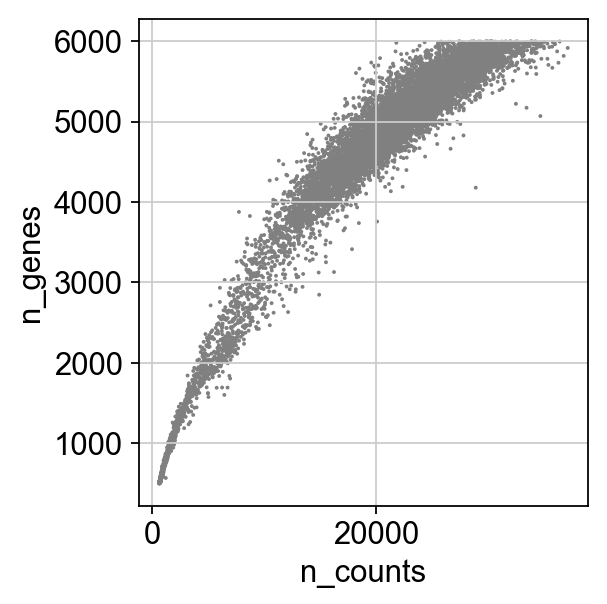

In [156]:
#Let's plot n_genes and percent_mito against n_counts: 
sc.pl.scatter(adata_HEK, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_HEK, x='n_counts',y='n_genes')

In this data set it seems like the majority of our cells had mito around 6-10%. It looks like the low mito cells are actually our outliers, so let's filter out for those

In [157]:
adata_HEK=adata_HEK[adata_HEK.obs['percent_mito']>.02, :]

#filter out any cells with fewer than 2000 reads per cell
adata_HEK=adata_HEK[adata_HEK.obs['n_counts']>2000, :]
adata_HEK

View of AnnData object with n_obs × n_vars = 8789 × 20864 
    obs: 'Channel', 'batch', 'louvain_labels', 'n_counts', 'n_genes', 'passed_qc', 'percent_mito'
    var: 'gene_ids', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'

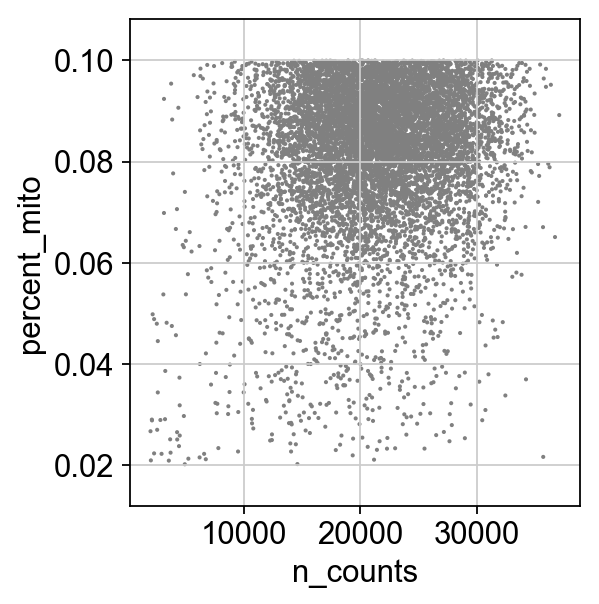

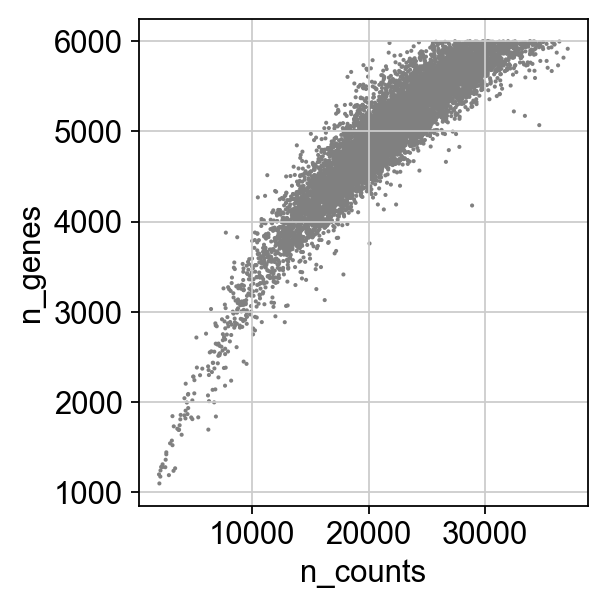

In [158]:
#Let's plot n_genes and percent_mito against n_counts: 
sc.pl.scatter(adata_HEK, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_HEK, x='n_counts',y='n_genes')

In [159]:
#save the result
adata_HEK.write(results_file2)

__Concatenate Part I + Part II__

First let's re-initialize our data objects

In [160]:
#Data from Part 1
adata_train=anndata.read_h5ad(results_file)
adata_train

AnnData object with n_obs × n_vars = 8115 × 21646 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

In [161]:
#Read in our Part II data
adata_HEK=anndata.read_h5ad(results_file2)
adata_HEK

AnnData object with n_obs × n_vars = 8789 × 20864 
    obs: 'Channel', 'batch', 'louvain_labels', 'n_counts', 'n_genes', 'passed_qc', 'percent_mito'
    var: 'gene_ids', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'

In [162]:
adata_train.obs

Channel  n_genes  n_counts demux_type assignment  \
index                                                               
AAACCCAAGCCTCAAT             4742   19631.0    singlet      HEK_2   
AAACCCAAGTCTTCGA             4630   23052.0    singlet     A375_9   
AAACCCAAGTTAGTGA             3093   10843.0    singlet    A375_14   
AAACCCACAAGCGGAT             4575   22472.0    singlet    A375_14   
AAACCCACATCAGTGT             4772   18852.0    singlet      HEK_8   
...                  ...      ...       ...        ...        ...   
TTTGGTTCATAGAAAC             3110   11410.0    singlet     HEK_10   
TTTGGTTCATCTAACG             3130   10025.0    singlet     A375_9   
TTTGGTTGTTGAGAGC             3772   14953.0    singlet      HEK_2   
TTTGTTGGTTCTCCTG             2968    8777.0    singlet    A375_15   
TTTGTTGTCCTTATGT             3503   11319.0    singlet      HEK_2   

                  percent_mito  
index                           
AAACCCAAGCCTCAAT      0.087107  
AAACCCAAGTCTTCGA      0.083247  
AAACCCAAGTTAGTGA      0.093517  
AAACCCACAAGCGGAT      0.062745  
AAACCCACATCAGTGT      0.069170  
...                        ...  
TTTGGTTCATAGAAAC      0.092287  
TTTGGTTCATCTAACG      0.056758  
TTTGGTTGTTGAGAGC      0.108406  
TTTGTTGGTTCTCCTG      0.064031  
TTTGTTGTCCTTATGT      0.095857  

[8115 rows x 6 columns]

In [163]:
adata_train.obs['Channel']=adata_train.obs['assignment']
adata_train.obs['Channel']

index
AAACCCAAGCCTCAAT      HEK_2
AAACCCAAGTCTTCGA     A375_9
AAACCCAAGTTAGTGA    A375_14
AAACCCACAAGCGGAT    A375_14
AAACCCACATCAGTGT      HEK_8
                     ...   
TTTGGTTCATAGAAAC     HEK_10
TTTGGTTCATCTAACG     A375_9
TTTGGTTGTTGAGAGC      HEK_2
TTTGTTGGTTCTCCTG    A375_15
TTTGTTGTCCTTATGT      HEK_2
Name: Channel, Length: 8115, dtype: category
Categories (8, object): [A375_9, A375_13, A375_14, A375_15, HEK_2, HEK_8, HEK_10, HEK_12]

In [164]:
#re-label the Channel column so we can differentiate later on
adata_HEK.obs['Channel']='HEK_exp'

In [165]:
adata_HEK.obs

Channel batch louvain_labels  n_counts  n_genes  \
index                                                                       
HEK_1-AAACCCAGTACTCGTA-0  HEK_exp     0              2   23178.0     5085   
HEK_1-AAACGAAGTTCGGGTC-0  HEK_exp     0              3   15376.0     3922   
HEK_1-AAACGCTGTTGCAACT-0  HEK_exp     0              2   11121.0     4285   
HEK_1-AAACGCTTCGAAACAA-0  HEK_exp     0              4   27768.0     5555   
HEK_1-AAAGAACCACAAAGCG-0  HEK_exp     0              3   23837.0     5005   
...                           ...   ...            ...       ...      ...   
HEK_4-TTTGATCGTTAATGAG-3  HEK_exp     3              4   24542.0     5304   
HEK_4-TTTGGAGCACGGTCTG-3  HEK_exp     3              2   24809.0     5376   
HEK_4-TTTGGAGCATGGAAGC-3  HEK_exp     3              2   24574.0     5717   
HEK_4-TTTGGTTGTTTGGGTT-3  HEK_exp     3              4   16296.0     4922   
HEK_4-TTTGTTGCAGTCAGCC-3  HEK_exp     3              3   26266.0     5323   

                          passed_qc  percent_mito  
index                                              
HEK_1-AAACCCAGTACTCGTA-0       True      0.093062  
HEK_1-AAACGAAGTTCGGGTC-0       True      0.084092  
HEK_1-AAACGCTGTTGCAACT-0       True      0.073285  
HEK_1-AAACGCTTCGAAACAA-0       True      0.059457  
HEK_1-AAAGAACCACAAAGCG-0       True      0.093091  
...                             ...           ...  
HEK_4-TTTGATCGTTAATGAG-3       True      0.083367  
HEK_4-TTTGGAGCACGGTCTG-3       True      0.086622  
HEK_4-TTTGGAGCATGGAAGC-3       True      0.096443  
HEK_4-TTTGGTTGTTTGGGTT-3       True      0.080940  
HEK_4-TTTGTTGCAGTCAGCC-3       True      0.096817  

[8789 rows x 7 columns]

Let's concatenate our experimental HEK data with our training data

In [166]:
adata_conc=adata_HEK.concatenate(adata_train, join="inner")
adata_conc

AnnData object with n_obs × n_vars = 16904 × 19920 
    obs: 'Channel', 'assignment', 'batch', 'demux_type', 'louvain_labels', 'n_counts', 'n_genes', 'passed_qc', 'percent_mito'
    var: 'gene_ids', 'n_cells-0', 'percent_cells-0', 'robust-0', 'highly_variable_features-0', 'mean-0', 'var-0', 'hvf_loess-0', 'hvf_rank-0', 'robust-1', 'n_cells-1'

__Visualize__

Let's take a look:

... storing 'Channel' as categorical
... storing 'assignment' as categorical
... storing 'demux_type' as categorical
... storing 'louvain_labels' as categorical
... storing 'passed_qc' as categorical


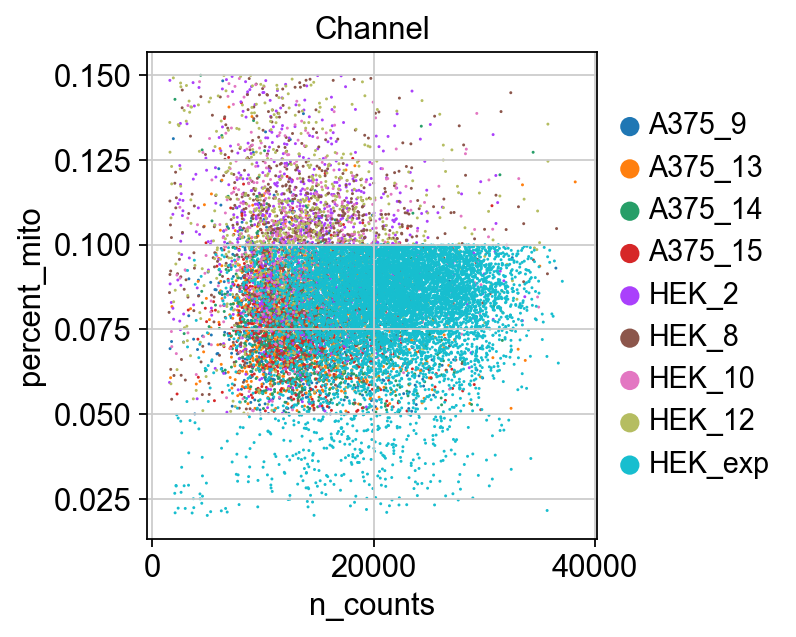

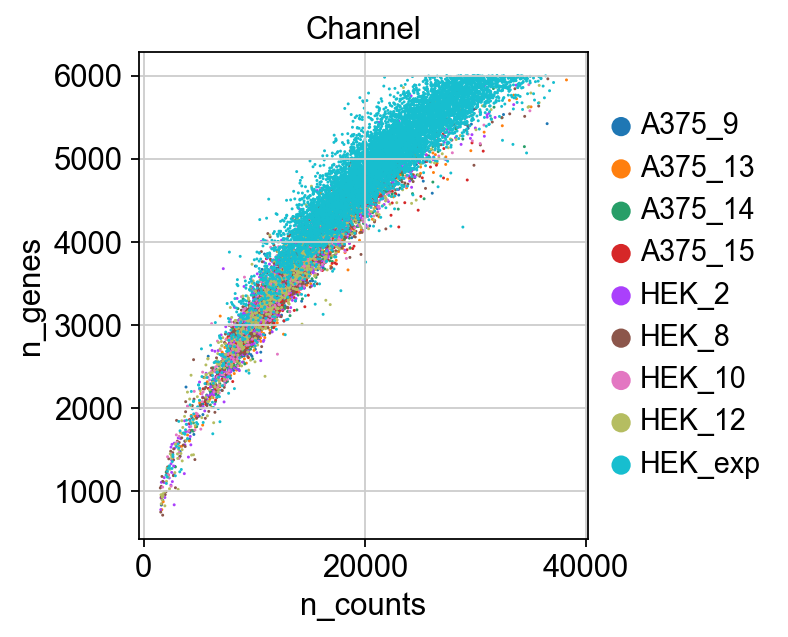

In [167]:
sc.pl.scatter(adata_conc, x='n_counts', y='percent_mito', color='Channel')
sc.pl.scatter(adata_conc, x='n_counts',y='n_genes', color='Channel')

__Norm & Scale__

In [168]:
sc.pp.normalize_per_cell(adata_conc, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [169]:
sc.pp.log1p(adata_conc)

In [170]:
#Identify highly variable genes
sc.pp.highly_variable_genes(adata_conc, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


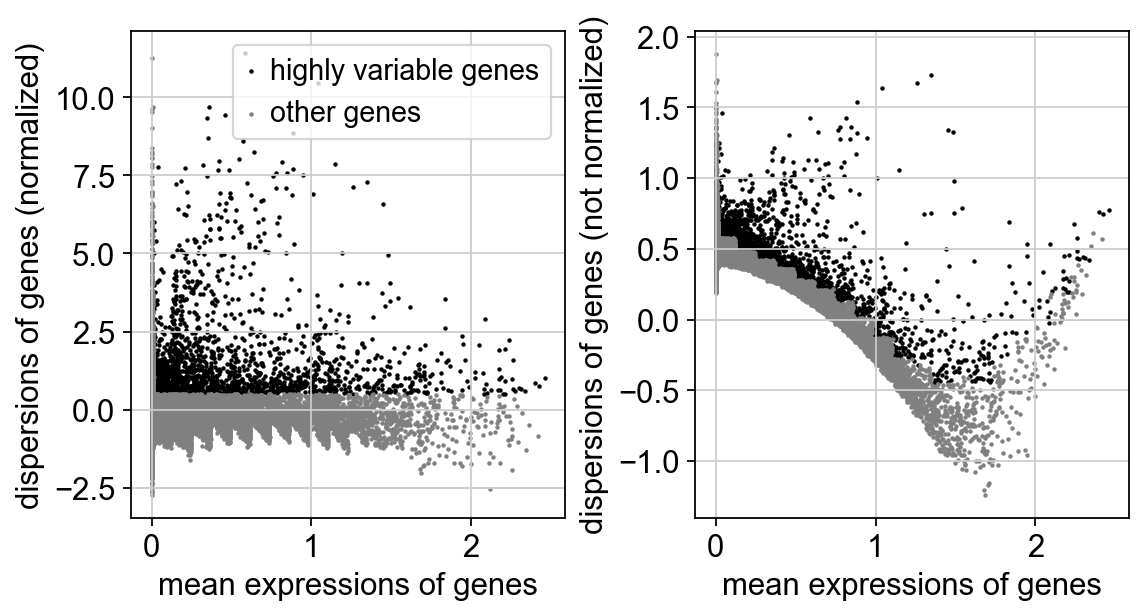

In [171]:
sc.pl.highly_variable_genes(adata_conc)

In [172]:
#filter 
adata_conc=adata_conc[:, adata_conc.var['highly_variable']]

#regress out effects of n counts and % mito
sc.pp.regress_out(adata_conc, ['n_counts','percent_mito'])

# Clip values exceeding standard deviation 10
sc.pp.scale(adata_conc, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:20)


__PCA__

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)


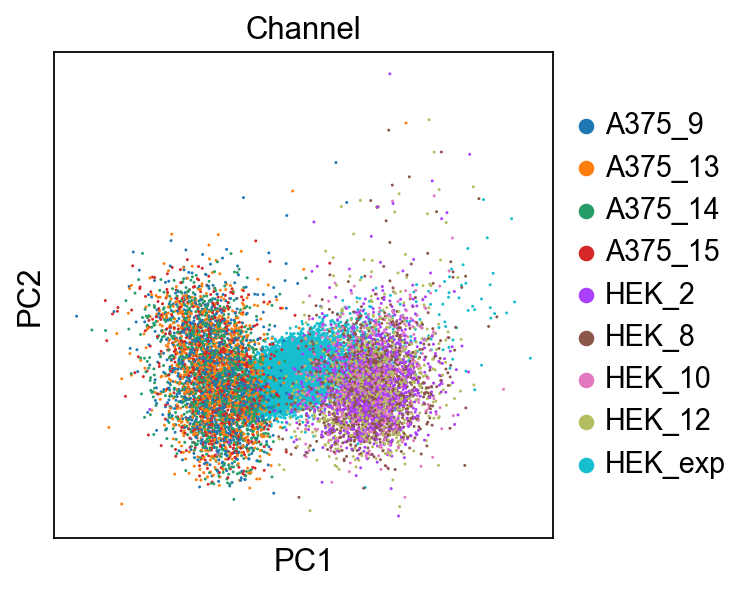

In [173]:
#Principal component analysis to reduce dimensionality of the data
sc.tl.pca(adata_conc, svd_solver='arpack')

#scatter plot in the PCA coordinates
sc.pl.pca(adata_conc, color='Channel')

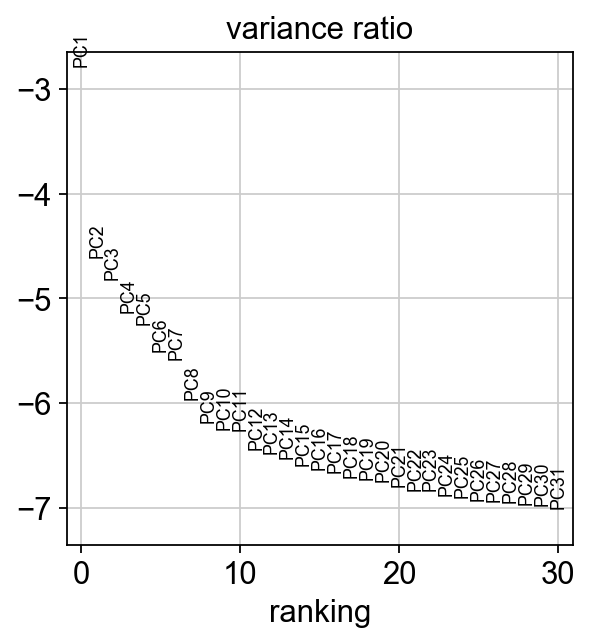

In [174]:
#Let's inspect the contribution of single PCs to the total variance in the data.

sc.pl.pca_variance_ratio(adata_conc, log=True)

25 looks good.

In [175]:
#Computing the neighborhood graph using the PCA representation
sc.pp.neighbors(adata_conc, n_neighbors=10, n_pcs=25)

#Embedding the graph in 2 dimensions using UMAP
sc.tl.umap(adata_conc)

computing neighbors
    using 'X_pca' with n_pcs = 25


/Users/caroline/opt/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


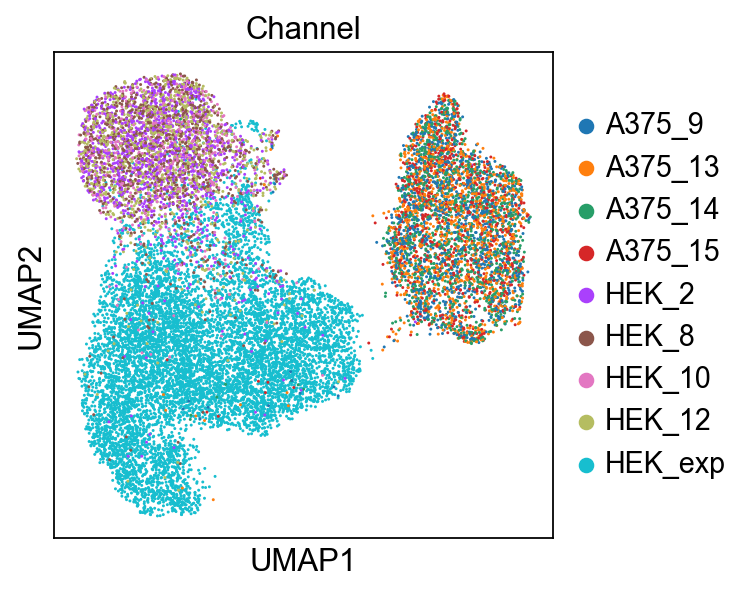

In [176]:
sc.pl.umap(adata_conc, color=['Channel'])

__Conclusion__

We can see that our HEK_exp cells cluster closer to the HEK_train samples, which is good, and the A375 cluster is more separated from the pother cell types. However the experimental HEK cells clearly form a separate cluster than our training HEK cells, which indicates that our two HEK cell populations had different gene expressions.  This is likely due to the fact that our training HEK cells were stressed out during the validation experiment.

In general, I would say that my analysis was successful and my model worked as a general a proof-of-concept. However it would not be totally usable in a scientific setting. Our training data was not perfect (as stated above, the HEK cells were very stressed out), which affects any clustering analysis.  Also, we wouldn't usually combine & compare data from two different experiments simply because the cells would have been handled differently and would confound our results.

It was still useful to play around with this data and become more familiar with this Python class, as I will be now able to use these skills at work. I would say the most challenging portion of this prtoject was learning how to manipulate AnnData objects - some of the logic behind manual manipulation is still difficult to understand. I had an especially difficult time when it came to concatenating the two different experimental data objects together - the HEK cells from Part II needed to be run through an additional pipeline, which I needed to read tutorials on in order to figure out how to execute them. 

Overall I learned a great deal and I will definitely be able to use what I learned in a professional setting.